In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data= pd.read_csv('House-Data.csv')

In [3]:
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
data=data.drop(columns=('id'))

<Axes: xlabel='price'>

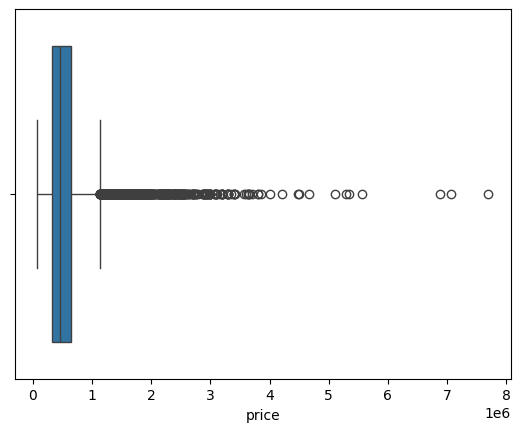

In [5]:
sns.boxplot(x='price', data=data)

In [ ]:
def replace_outliers(df):
    for col in df.select_dtypes(include=['number']).columns:  
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR 
        upper_bound = Q3 + 1.5 * IQR 
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col]) 

<Axes: >

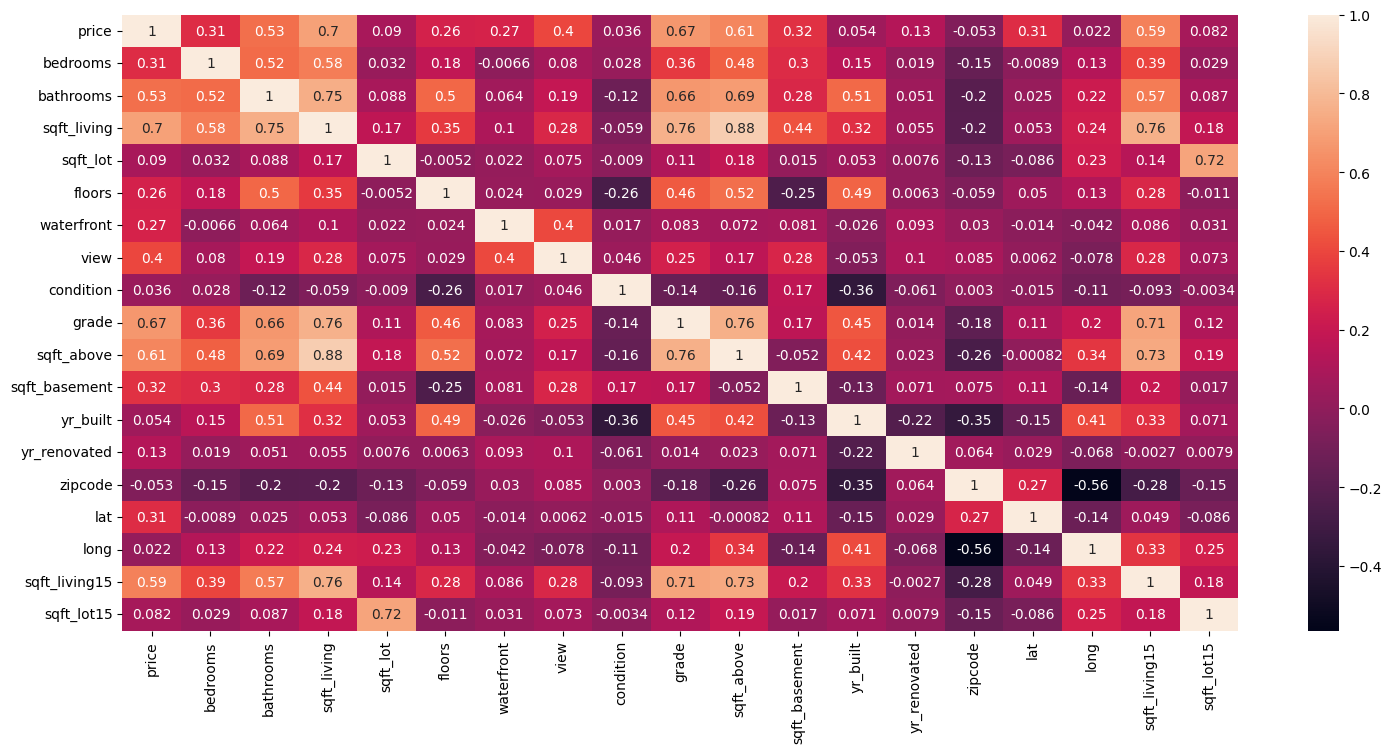

In [7]:
plt.figure(figsize=(18, 8))
sns.heatmap(data.select_dtypes('number').corr(),annot=True)

In [ ]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year']=data['date'].dt.year
data['month']=data['date'].dt.month
data['day']=data['date'].dt.day
data.drop(columns=('date'),axis=1, inplace=True)

In [9]:
# Séparation X/y
X = data.drop('price', axis=1)
y = data['price']

In [10]:
# Colonnes
cat_cols = ['zipcode']
num_cols = [col for col in X.columns if col not in cat_cols]

In [11]:
# Prétraitement
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [12]:
# Modèle
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', xgb_model)
])


In [13]:
# Recherche hyperparamètres
param_dist = {
    'regressor__max_depth': randint(3, 11),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__n_estimators': randint(50, 200),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
    'regressor__gamma': uniform(0.3)
}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['bedrooms',
                                                                                'bathrooms',
                                                                                'sqft_living',
                                                                                'sqft_lot',
                                                                                'floors',
                                                                                'waterfront',
                                                                                'view',
                                                                                'condition',
                                                                                'grade',
                                                                                'sqft_above',
                                                                                'sqft_basement',
                                                                                'yr_built',
                                                                                'yr_renovated',
                                                                                'lat',
                                                                                'long',
                                                                                'sqft_living15',
                                                                                'sqft_lot15',
                                                                                'year',
                                                                                'month',
                                                                                'day']),
                                                                              ('cat',
                                                                               On...
                                        'regressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029D2954F040>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029D29582CB0>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000029D29564700>},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [15]:
# Évaluation
best_models = search.best_estimator_
y_pred = best_models.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MSE : {mse:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R² : {r2:.4f}")


MSE : 19,843,578,519.09
RMSE : 140,867.24
R² : 0.8687


In [16]:
# Sauvegarde du modèle complet
pickle.dump(best_models,open('best_models.pkl', 'wb')) 
    
